In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import shutil
import glob
import pickle
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve
%matplotlib inline
print(tf.__version__)

1.13.1


### Test CSV path

In [10]:
path_feature = r'C:\Users\sekaranh\Documents\Python Scripts\safty\dataset\features'
path_label = r'C:\Users\sekaranh\Documents\Python Scripts\safty\dataset\labels'

In [11]:
def read_dataset(path_feature, path_label):
    all_files_feature = glob.glob(path_feature + "/*.csv")
    all_files_label = glob.glob(path_label + "/*.csv")
    li=[]
    for filename in all_files_feature:
        df = pd.read_csv(filename, index_col=None, header=0)
        li.append(df)
    df_features = pd.concat(li, axis=0, ignore_index=True)
    li=[]
    for filename in all_files_label:
        df = pd.read_csv(filename, index_col=None, header=0)
        li.append(df)
    df_labels = pd.concat(li, axis=0, ignore_index=True)
    dfRaw= (pd.merge(df_features, df_labels, left_on='bookingID', right_on='bookingID', how='left'))
    return dfRaw, df_labels
dfRaw, df_labels = read_dataset(path_feature, path_label )

In [13]:
RELEVANT_EVENTS = ['bookingID','acceleration_x', 'acceleration_y', 'acceleration_z','gyro_x','gyro_y','gyro_z',
        'second', 'Bearing', 'Speed', 'label']

def prepData(dfPrepData, minRecordsPerSubscriber = 1):
    dfPrepData.reset_index(inplace=True)
    print("*** Starting data prep. Length:",len(dfPrepData),"***")
  
    
    #Remove NAs
    dfPrepData = dfPrepData.dropna()
    print("Removed NAs. Length:",len(dfPrepData))
    
    #Remove Negative Speed
    #dfPrepData['Speed']=dfPrepData.Speed.clip(0,10000)
    print("Changing Speed to abs Speed")
    #dfPrepData['Speed']=abs(dfPrepData['Speed'])
    dfPrepData.drop(dfPrepData[dfPrepData['Speed'] >  100].index, inplace=True) 
    dfPrepData.drop(dfPrepData[dfPrepData['Speed'] <  0].index, inplace=True) 
    
    #Filter out second more then 86400 second, 24H
    dfPrepData.drop(dfPrepData[dfPrepData['second'] >  86400].index, inplace=True)
    print("Filter out second more than 86400 second, 24H")
    
    dfPrepData.drop(dfPrepData[dfPrepData['Accuracy'] >  50].index, inplace=True)
    print("Drop coloum accuracy less then 50")

    # Filter out unwanted events
    drop_these = list(set(list(dfPrepData)) - set(RELEVANT_EVENTS))
    df =  dfPrepData.drop(drop_these, axis = 1)
    return df
df = prepData(dfRaw)

*** Starting data prep. Length: 16154418 ***
Removed NAs. Length: 16154418
Changing Speed to abs Speed
Filter out second more than 86400 second, 24H
Drop coloum accuracy less then 50


In [14]:
## reference https://wiki.dfrobot.com/How_to_Use_a_Three-Axis_Accelerometer_for_Tilt_Sensing
#pitch = atan2((- x_Buff) , sqrt(y_Buff * y_Buff + z_Buff * z_Buff)) * 57.3;
#df['pitch'] = np.arctan2(df['acceleration_y']/np.sqrt(np.square(df['acceleration_x'])+np.square(df['acceleration_z'])))
df['f_pitch'] = np.arctan2(-df['acceleration_y'],np.sqrt(np.square(df['acceleration_z'])+np.square(df['acceleration_x'])))*57.3
#roll = atan2(y_Buff , z_Buff) * 57.3;
df['f_roll'] = np.arctan2(df['acceleration_z'],df['acceleration_x'])*57.3
df['f_gyro'] = abs(df['gyro_x']) + abs(df['gyro_y']) + abs(df['gyro_z'])
df['f_accel'] = abs(df['acceleration_x']) + abs(df['acceleration_y']) + abs(df['acceleration_z'])
df['f_bearing'] = df['Bearing']
df['f_speed'] =  df['Speed']

In [15]:
print("finding orentation and swaping acceleration")
m = abs(df['acceleration_y']) < abs(df['acceleration_z'])
df.loc[m, ['acceleration_y', 'acceleration_z']] = df.loc[m, ['acceleration_z', 'acceleration_y']].values 

finding orentation and swaping acceleration


In [16]:
print("finding acceleration mean and offseting the values")
df['acceleration_z']= df.groupby('bookingID')['acceleration_z'].transform(lambda x: (x - x.mean()/2))#/x.std())
df['acceleration_x']= df.groupby('bookingID')['acceleration_x'].transform(lambda x: (x - x.mean()))#/x.std())
df['acceleration_y']= df.groupby('bookingID')['acceleration_y'].transform(lambda x: (x - x.mean()))#/x.std())
df['f_diffPitchMean']= df.groupby('bookingID')['f_pitch'].transform(lambda x: (x - x.mean()))
df['f_diffRollMean']= df.groupby('bookingID')['f_roll'].transform(lambda x: (x - x.mean()))

finding acceleration mean and offseting the values


In [17]:
#parameter turning values
hash_acceleration_value = 3 #m/s
hash_braking_value = -2 
hash_turn_value = 2
hash_bump_value = 3
hash_pitch_value =10
hash_roll_value =20
max_speed_value = 100

In [18]:
def create_newFeature(df_feature):
    df_feature['speed_km/h'] = df_feature['Speed']*3.6
    #df_feature['harshAcceleration'] = df_feature['acceleration_z'].apply(lambda x: 1 if (x > hash_acceleration_value and x < hash_acceleration_value+2)   else 0)
    df_feature['harshAcceleration1'] = df_feature['acceleration_z'].apply(lambda x: 1 if (x > hash_acceleration_value+2)   else 0)
    df_feature['harshBraking'] = df_feature['acceleration_z'].apply(lambda x: 1 if (x < hash_braking_value and x > hash_braking_value-2 ) else 0)
    #df_feature['harshBraking1'] = df_feature['acceleration_z'].apply(lambda x: 1 if (x < hash_braking_value-2 ) else 0)
    df_feature['harsh_orientationChange'] = df_feature['f_gyro'].apply(lambda x: 1 if abs(x) > 1 else 0)
    df_feature['harsh_speed_limit'] = df_feature['speed_km/h'].apply(lambda x: 1 if x > max_speed_value else 0)
    #df_feature['harshTurn'] = df_feature['acceleration_x'].apply(lambda x: 1 if (abs(x) > hash_turn_value and abs(x) < hash_turn_value+2 ) else 0)
    df_feature['harshTurn1'] = df_feature['acceleration_x'].apply(lambda x: 1 if (abs(x) > hash_turn_value+2 ) else 0)
    df_feature['harshBump'] = df_feature['acceleration_y'].apply(lambda x: 1 if (abs(x) > hash_bump_value and abs(x) < hash_bump_value+2) else 0)
    df_feature['harshBump1'] = df_feature['acceleration_y'].apply(lambda x: 1 if (abs(x) > hash_bump_value+2) else 0)
    df_feature['harshPitch'] = df_feature['f_diffPitchMean'].apply(lambda x: 1 if (abs(x) > hash_pitch_value and abs(x)< hash_pitch_value+10) else 0)
    #df_feature['harshPitch1'] = df_feature['f_diffPitchMean'].apply(lambda x: 1 if (abs(x) > hash_pitch_value+10) else 0) 
    #df_feature['harshRoll'] = df_feature['f_diffRollMean'].apply(lambda x: 1 if (abs(x) > hash_roll_value and abs(x)< hash_roll_value+10) else 0)
    df_feature['harshRoll1'] = df_feature['f_diffRollMean'].apply(lambda x: 1 if (abs(x) > hash_pitch_value) else 0)
    return df_feature
df=create_newFeature(df)
#df.head(10)

,bookingID,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed,...,speed_km/h,harshAcceleration1,harshBraking,harsh_orientationChange,harsh_speed_limit,harshTurn1,harshBump,harshBump1,harshPitch,harshRoll1
0,1202590843006,353.000000,-0.013363,-0.078228,1.987693,0.008221,0.002269,-0.009966,1362.0,0.000000,...,0.000000,0,0,0,0,0,0,0,0,0
1,274877907034,17.000000,-0.314958,-0.320901,2.671609,0.024629,0.004028,-0.010858,257.0,0.190000,...,0.684000,0,0,0,0,0,0,0,0,0
2,884763263056,189.000000,0.683887,0.101542,0.635214,-0.006899,-0.015080,0.001122,973.0,0.667059,...,2.401412,0,0,0,0,0,0,0,0,1
3,1073741824054,126.000000,3.170591,0.620177,-0.318553,0.001344,-0.339601,-0.017956,902.0,7.913285,...,28.487827,0,0,0,0,0,0,0,1,1
4,1056561954943,50.000000,-0.059949,0.814877,-1.047925,0.130568,-0.061697,0.161530,820.0,20.419409,...,73.509872,0,0,0,0,0,0,0,0,1
5,1185410973787,178.000000,0.291399,0.203535,0.979060,-0.057104,-0.043555,0.002334,533.0,19.250000,...,69.300000,0,0,0,0,0,0,0,0,0
6,163208757379,262.184418,0.176449,0.116111,-1.212140,0.026767,-0.030687,-0.006071,556.0,2.110000,...,7.596000,0,0,0,0,0,0,0,0,0
7,884763262976,48.000000,-0.168153,0.120469,-0.080335,-0.000698,-0.001902,0.015586,200.0,0.000000,...,0.000000,0,0,0,0,0,0,0,0,1
8,841813590178,44.041702,-0.075828,0.016358,-2.686548,0.013766,-0.017083,0.003231,115.0,13.914648,...,50.092733,0,1,0,0,0,0,0,0,0
9,300647710810,165.000000,0.053941,-0.029381,2.093630,0.021364,0.001613,0.009384,824.0,26.602882,...,95.770375,0,0,0,0,0,0,0,0,0


In [20]:
def cluster_Feature(df):
    prefixes = ["harsh", "speed",'orientation']
    prefixes_f = ['f_']
    df_safty = pd.DataFrame()
    bookingIDs= df.bookingID.unique()
    df_safty['bookingID'] = bookingIDs
    for df_columns_name in df.columns :
        if df_columns_name.startswith(tuple(prefixes)):
                df_safty1 =df.groupby('bookingID')[df_columns_name].sum().reset_index()
                df_safty = pd.merge(df_safty,df_safty1, left_on='bookingID', right_on='bookingID', how='left')
        if df_columns_name.startswith(tuple(prefixes_f)):
                df_safty1 =df.groupby('bookingID')[df_columns_name].mean().reset_index()
                df_safty1.columns = ['bookingID', df_columns_name+"_mean"]
                df_safty = pd.merge(df_safty,df_safty1, left_on='bookingID', right_on='bookingID', how='left')
                df_safty1 =df.groupby('bookingID')[df_columns_name].max().reset_index()
                df_safty1.columns = ['bookingID', df_columns_name+"_max"]
                df_safty = pd.merge(df_safty,df_safty1, left_on='bookingID', right_on='bookingID', how='left')
                df_safty1 =df.groupby('bookingID')[df_columns_name].std().reset_index()
                df_safty1.columns = ['bookingID', df_columns_name+"_std"]
                df_safty = pd.merge(df_safty,df_safty1, left_on='bookingID', right_on='bookingID', how='left')
                
    return df_safty
df_safty=cluster_Feature(df)
#df_safty.head(10)

In [21]:
def total_distance(oneBooking):
    return (oneBooking.second.count()* (abs(oneBooking.Speed.mean()) if oneBooking.Speed.mean() > 5.5 else 5.5))#
def calculate_overall_distance_travelled(dfRaw):
    dfDistancePerBooking = dfRaw.groupby('bookingID').apply(total_distance).reset_index(name='Distance')
    return dfDistancePerBooking
distancePerBooking = calculate_overall_distance_travelled(dfRaw)
distancePerBooking.head(10)

,bookingID,Distance
0,0,9030.801222
1,1,6707.231233
2,2,1072.500000
3,4,6729.190006
4,6,6022.500000
5,7,11555.390349
6,8,2128.500000
7,10,3263.260000
8,11,1498.280320
9,13,38121.830622


In [23]:
def create_feature_set(df, distancePerBooking):
    dfEventMatrix = df.merge(distancePerBooking, how = 'inner',on='bookingID')
    dfEventMatrix.set_index('bookingID', inplace=True)
    featureCols = [col for col in dfEventMatrix if col.startswith('harsh')]
    dfEventMatrix[featureCols] = dfEventMatrix[featureCols].div(dfEventMatrix['Distance'], axis=0)
    dfFeatureSet = dfEventMatrix[featureCols]
    return dfFeatureSet
features_h = create_feature_set(df_safty,distancePerBooking)
#features_h.head(10)

In [24]:
def create_feature_set_stats(df):
    dfEventMatrix = df.merge(distancePerBooking, how = 'inner',on='bookingID')
    dfEventMatrix.set_index('bookingID', inplace=True)
    featureCols = [col for col in dfEventMatrix if col.startswith('f_')]
    dfEventMatrix[featureCols] = dfEventMatrix[featureCols]
    dfFeatureSet = dfEventMatrix[featureCols]
    return dfFeatureSet
features_f = create_feature_set_stats(df_safty)
features_f.head(10)

,f_pitch_mean,f_pitch_max,f_pitch_std,f_roll_mean,f_roll_max,f_roll_std,f_gyro_mean,f_gyro_max,f_gyro_std,f_accel_mean,...,f_bearing_std,f_speed_mean,f_speed_max,f_speed_std,f_diffPitchMean_mean,f_diffPitchMean_max,f_diffPitchMean_std,f_diffRollMean_mean,f_diffRollMean_max,f_diffRollMean_std
bookingID,,,,,,,,,,,,,,,,,,,,,
1202590843006,-64.837750,-44.538162,5.429195,72.580326,107.290855,8.643165,0.128275,1.434643,0.140190,14.252863,...,143.907886,5.478918,18.990440,5.732741,-3.493760e-15,20.299588,5.429195,1.146177e-14,34.710529,8.643165
274877907034,-65.082031,-46.831932,3.022887,85.145208,121.674479,6.560348,0.044282,0.759614,0.082900,13.543135,...,71.211362,12.913280,28.640000,11.169404,-1.210129e-14,18.250099,3.022887,-6.068300e-15,36.529270,6.560348
884763263056,-73.748060,-44.134165,4.211050,80.554689,155.637784,16.376951,0.178186,1.470241,0.162585,12.735690,...,85.131901,13.417964,26.932220,9.531138,1.104766e-14,29.613894,4.211050,-8.102755e-15,75.083095,16.376951
1073741824054,-82.151584,-50.663214,4.919205,19.932308,178.388163,60.723691,0.162036,1.964139,0.176177,11.499177,...,71.371384,6.684724,19.299793,5.826049,-9.024709e-15,31.488369,4.919205,1.201253e-15,158.455855,60.723691
1056561954943,-80.868123,-30.161016,5.329658,-62.946016,179.139767,79.726278,0.247938,1.831357,0.192675,11.704251,...,115.781825,16.231690,24.057781,6.288745,8.479143e-15,50.707108,5.329658,1.168448e-15,242.085783,79.726278
1185410973787,-65.367835,-31.689210,7.299940,80.973803,167.516327,23.284773,0.185568,1.639538,0.186100,13.832816,...,82.011956,9.690571,29.310000,7.925855,1.917951e-15,33.678625,7.299940,-1.351576e-15,86.542524,23.284773
163208757379,73.698230,85.114058,3.610530,-80.049274,-21.810317,13.840894,0.141572,0.785529,0.116478,12.498816,...,64.505923,5.769024,17.170000,5.167500,-4.911931e-15,11.415828,3.610530,5.343131e-15,58.238957,13.840894
884763262976,-85.093847,-51.750228,4.086655,-32.013353,179.845084,70.585148,0.194743,1.496009,0.213007,11.000451,...,75.651723,5.714645,18.217026,5.951634,-5.716333e-15,33.343620,4.086655,-1.279650e-15,211.858438,70.585148
841813590178,49.772782,64.175924,4.401956,-77.084731,-43.622900,7.436683,0.122474,0.933569,0.128073,14.821208,...,77.860492,13.256026,32.242214,10.253407,-6.694709e-15,14.403142,4.401956,7.947400e-15,33.461831,7.436683


In [25]:
features = pd.merge(features_h,features_f, left_on='bookingID', right_on='bookingID', how='left')
features.head()

,harshAcceleration1,harshBraking,harsh_orientationChange,harsh_speed_limit,harshTurn1,harshBump,harshBump1,harshPitch,harshRoll1,f_pitch_mean,...,f_bearing_std,f_speed_mean,f_speed_max,f_speed_std,f_diffPitchMean_mean,f_diffPitchMean_max,f_diffPitchMean_std,f_diffRollMean_mean,f_diffRollMean_max,f_diffRollMean_std
bookingID,,,,,,,,,,,,,,,,,,,,,
1202590843006,0.000474,0.000000,0.000316,0.000000,0.000000,0.000316,0.000000,0.015797,0.031277,-64.837750,...,143.907886,5.478918,18.990440,5.732741,-3.493760e-15,20.299588,5.429195,1.146177e-14,34.710529,8.643165
274877907034,0.000000,0.000000,0.000000,0.000192,0.000000,0.000000,0.000000,0.000818,0.006974,-65.082031,...,71.211362,12.913280,28.640000,11.169404,-1.210129e-14,18.250099,3.022887,-6.068300e-15,36.529270,6.560348
884763263056,0.000045,0.000000,0.000180,0.000000,0.000000,0.000090,0.000000,0.002696,0.032395,-73.748060,...,85.131901,13.417964,26.932220,9.531138,1.104766e-14,29.613894,4.211050,-8.102755e-15,75.083095,16.376951
1073741824054,0.000287,0.004585,0.000430,0.000000,0.000000,0.001003,0.000143,0.005588,0.115778,-82.151584,...,71.371384,6.684724,19.299793,5.826049,-9.024709e-15,31.488369,4.919205,1.201253e-15,158.455855,60.723691
1056561954943,0.000000,0.004586,0.000274,0.000000,0.000137,0.000685,0.000137,0.002807,0.055036,-80.868123,...,115.781825,16.231690,24.057781,6.288745,8.479143e-15,50.707108,5.329658,1.168448e-15,242.085783,79.726278


In [28]:
import scipy.stats as st

def transform_to_normal_boxcox(x,min_max_transform = False):
    xt = np.zeros(len(x))
    if np.count_nonzero(x) == 0:
        print("only zero valued values found")
        return x
    
    valueGreaterThanZero = np.where(x<=0,0,1)
    positives = x[valueGreaterThanZero == 1]
    if(len(positives)> 0):
        xt[valueGreaterThanZero == 1],_ = st.boxcox(positives+1)
    if min_max_transform:
        xt = (xt - np.min(xt)) / (np.max(xt)-np.min(xt))
    return xt

transFeatures = features.apply(lambda x: (transform_to_normal_boxcox(x,min_max_transform = True)))
transFeatures.head()

,harshAcceleration1,harshBraking,harsh_orientationChange,harsh_speed_limit,harshTurn1,harshBump,harshBump1,harshPitch,harshRoll1,f_pitch_mean,...,f_bearing_std,f_speed_mean,f_speed_max,f_speed_std,f_diffPitchMean_mean,f_diffPitchMean_max,f_diffPitchMean_std,f_diffRollMean_mean,f_diffRollMean_max,f_diffRollMean_std
bookingID,,,,,,,,,,,,,,,,,,,,,
1202590843006,0.218470,0.00000,0.073928,0.00000,0.000000,0.171328,0.000000,0.797149,0.254545,0.0,...,NaN,0.479921,0.181667,NaN,0.000000,0.629541,NaN,0.770553,0.350050,NaN
274877907034,0.000000,0.00000,0.000000,0.04752,0.000000,0.000000,0.000000,0.079827,0.061037,0.0,...,NaN,0.720439,0.286302,NaN,0.000000,0.610222,NaN,0.000000,0.359162,NaN
884763263056,0.023105,0.00000,0.042752,0.00000,0.000000,0.052055,0.000000,0.239685,0.262778,0.0,...,NaN,0.732369,0.267432,NaN,0.721758,0.698011,NaN,0.000000,0.509897,NaN
1073741824054,0.138501,0.30742,0.099222,0.00000,0.000000,0.449234,0.040730,0.432901,0.747699,0.0,...,NaN,0.531165,0.184939,NaN,0.000000,0.709110,NaN,0.129418,0.719293,NaN
1056561954943,0.000000,0.30748,0.064399,0.00000,0.064102,0.334434,0.038951,0.248186,0.418357,0.0,...,NaN,0.793071,0.235992,NaN,0.616454,0.794769,NaN,0.129418,0.868639,NaN


In [29]:
### remove outliers
import seaborn as sns
sns.set(style="ticks")

def replace_outliers_with_limit(x, stdFactor =10, normalize = False):
    print(x.name)
    x = x.values
    xt = np.zeros(len(x))
    if np.count_nonzero(x) == 0:
        print("only zero valued values found")
        return x
    
    xt = transform_to_normal_boxcox(x)

    xMean, xStd = np.mean(xt), np.std(xt)
    outliers = np.where(xt > xMean + stdFactor*xStd)[0]
    inliers = np.where(xt <= xMean + stdFactor*xStd)[0]
    if len(outliers) > 0:
        print("found outlier with factor: "+str(stdFactor)+" : "+str(outliers))
        xinline = x[inliers]
        maxInRange = np.max(xinline)
        print("replacing outliers {} with max={}".format(outliers,maxInRange))
        vals = x.copy()
        vals[outliers] = maxInRange
        x= pd.Series(vals)
    else:
        print("No outliers found")
    if normalize:
        #Normalize to [0,1]
        x = (x - np.min(x)) / (np.max(x)-np.min(x))
    return x

cleanFeatures = features.apply(lambda x: (replace_outliers_with_limit(x)))
cleanFeatures.head(6)

harshAcceleration1
No outliers found
harshAcceleration1
No outliers found
harshBraking
No outliers found
harsh_orientationChange
No outliers found
harsh_speed_limit
No outliers found
harshTurn1
No outliers found
harshBump
No outliers found
harshBump1
No outliers found
harshPitch
No outliers found
harshRoll1
No outliers found
f_pitch_mean
No outliers found
f_pitch_max
No outliers found
f_pitch_std
No outliers found
f_roll_mean
No outliers found
f_roll_max
No outliers found
f_roll_std
No outliers found
f_gyro_mean


C:\Users\sekaranh\AppData\Local\Continuum\anaconda3\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in less_equal
  if __name__ == '__main__':
C:\Users\sekaranh\AppData\Local\Continuum\anaconda3\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in greater
  app.launch_new_instance()
C:\Users\sekaranh\AppData\Local\Continuum\anaconda3\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in less_equal


No outliers found
f_gyro_max
No outliers found
f_gyro_std
No outliers found
f_accel_mean
found outlier with factor: 10 : [ 1121  2117  2312  2510  4065  5622  7205  7715  8062  8606  8801  9282
 12144 14030 15778 16252 17639 17876 18339]
replacing outliers [ 1121  2117  2312  2510  4065  5622  7205  7715  8062  8606  8801  9282
 12144 14030 15778 16252 17639 17876 18339] with max=25.947339537232953
f_accel_max
No outliers found
f_accel_std
No outliers found
f_bearing_mean
No outliers found
f_bearing_max
No outliers found
f_bearing_std
No outliers found
f_speed_mean
No outliers found
f_speed_max
found outlier with factor: 10 : [8078]
replacing outliers [8078] with max=56.698967
f_speed_std
No outliers found
f_diffPitchMean_mean
No outliers found
f_diffPitchMean_max
No outliers found
f_diffPitchMean_std
No outliers found
f_diffRollMean_mean
No outliers found
f_diffRollMean_max
No outliers found
f_diffRollMean_std
No outliers found


,harshAcceleration1,harshBraking,harsh_orientationChange,harsh_speed_limit,harshTurn1,harshBump,harshBump1,harshPitch,harshRoll1,f_pitch_mean,...,f_bearing_std,f_speed_mean,f_speed_max,f_speed_std,f_diffPitchMean_mean,f_diffPitchMean_max,f_diffPitchMean_std,f_diffRollMean_mean,f_diffRollMean_max,f_diffRollMean_std
bookingID,,,,,,,,,,,,,,,,,,,,,
1202590843006,0.000474,0.000000,0.000316,0.000000,0.000000,0.000316,0.000000,0.015797,0.031277,-64.837750,...,143.907886,5.478918,18.990440,5.732741,-3.493760e-15,20.299588,5.429195,1.146177e-14,34.710529,8.643165
274877907034,0.000000,0.000000,0.000000,0.000192,0.000000,0.000000,0.000000,0.000818,0.006974,-65.082031,...,71.211362,12.913280,28.640000,11.169404,-1.210129e-14,18.250099,3.022887,-6.068300e-15,36.529270,6.560348
884763263056,0.000045,0.000000,0.000180,0.000000,0.000000,0.000090,0.000000,0.002696,0.032395,-73.748060,...,85.131901,13.417964,26.932220,9.531138,1.104766e-14,29.613894,4.211050,-8.102755e-15,75.083095,16.376951
1073741824054,0.000287,0.004585,0.000430,0.000000,0.000000,0.001003,0.000143,0.005588,0.115778,-82.151584,...,71.371384,6.684724,19.299793,5.826049,-9.024709e-15,31.488369,4.919205,1.201253e-15,158.455855,60.723691
1056561954943,0.000000,0.004586,0.000274,0.000000,0.000137,0.000685,0.000137,0.002807,0.055036,-80.868123,...,115.781825,16.231690,24.057781,6.288745,8.479143e-15,50.707108,5.329658,1.168448e-15,242.085783,79.726278
1185410973787,0.002244,0.000841,0.000374,0.000467,0.000654,0.000280,0.000000,0.014865,0.037302,-65.367835,...,82.011956,9.690571,29.310000,7.925855,1.917951e-15,33.678625,7.299940,-1.351576e-15,86.542524,23.284773


In [30]:
## Pre step: Normalize features
minPerFeature = cleanFeatures.min()
maxPerFeature = cleanFeatures.max()

print("Min and Max values per column before normalization")
for col in range(0,len(cleanFeatures.columns)):
    print("{} range:[{},{}]".format(cleanFeatures.columns[col],minPerFeature[col],maxPerFeature[col]))

normalizedFeatures = (cleanFeatures-cleanFeatures.min())/(cleanFeatures.max()-cleanFeatures.min())
normalizedFeatures.head()


## Standardize features after box-cox as well.
transFeaturesScaled = (transFeatures - transFeatures.mean())/transFeatures.std()
print("")
print("Mean and STD before standardization")
for col in range(0,len(transFeatures.columns)):
    print("{} range:[{},{}]".format(transFeatures.columns[col],transFeatures.mean()[col],transFeatures.std()[col]))


normalizedFeatures.head()

Min and Max values per column before normalization
harshAcceleration1 range:[0.0,0.17575757575757575]
harshBraking range:[0.0,0.17835497835497835]
harsh_orientationChange range:[0.0,0.1771343410687673]
harsh_speed_limit range:[0.0,0.028425504807336188]
harshTurn1 range:[0.0,0.12371730018788843]
harshBump range:[0.0,0.12093023255813953]
harshBump1 range:[0.0,0.18071958253227136]
harshPitch range:[0.0,0.1420213697670345]
harshRoll1 range:[0.0,0.18181818181818182]
f_pitch_mean range:[-87.61548492994265,87.77504284674022]
f_pitch_max range:[-80.31136341003527,89.9984816934055]
f_pitch_std range:[0.2136042774211785,81.24312603733985]
f_roll_mean range:[-155.1084827397622,165.30348447481762]
f_roll_max range:[-130.3066939592289,180.01325905069513]
f_roll_std range:[0.26218814967231896,176.2257062805007]
f_gyro_mean range:[0.004842484009621755,19.345739832304137]
f_gyro_max range:[0.014061678200000002,105.7168355]
f_gyro_std range:[0.0,7.48347992242825]
f_accel_mean range:[1.0790281931559245,

,harshAcceleration1,harshBraking,harsh_orientationChange,harsh_speed_limit,harshTurn1,harshBump,harshBump1,harshPitch,harshRoll1,f_pitch_mean,...,f_bearing_std,f_speed_mean,f_speed_max,f_speed_std,f_diffPitchMean_mean,f_diffPitchMean_max,f_diffPitchMean_std,f_diffRollMean_mean,f_diffRollMean_max,f_diffRollMean_std
bookingID,,,,,,,,,,,,,,,,,,,,,
1202590843006,0.002696,0.000000,0.001784,0.000000,0.000000,0.002613,0.000000,0.111227,0.172024,0.129869,...,0.814268,0.185367,0.334934,0.435302,0.449315,0.123888,0.064367,0.716338,0.103898,0.047629
274877907034,0.000000,0.000000,0.000000,0.006768,0.000000,0.000000,0.000000,0.005757,0.038359,0.128476,...,0.402932,0.436891,0.505124,0.848121,0.305972,0.111380,0.034670,0.485046,0.109342,0.035792
884763263056,0.000256,0.000000,0.001015,0.000000,0.000000,0.000743,0.000000,0.018982,0.178170,0.079066,...,0.481698,0.453966,0.475004,0.723724,0.691477,0.180733,0.049333,0.458203,0.224743,0.091580
1073741824054,0.001631,0.025709,0.002427,0.000000,0.000000,0.008294,0.000793,0.039348,0.636781,0.031153,...,0.403837,0.226162,0.340391,0.442387,0.357207,0.192173,0.058073,0.580960,0.474300,0.343602
1056561954943,0.000000,0.025715,0.001546,0.000000,0.001107,0.005661,0.000758,0.019762,0.302700,0.038471,...,0.655123,0.549162,0.424307,0.477521,0.648703,0.309465,0.063138,0.580528,0.724626,0.451594


In [31]:
normalizedFeatures= (pd.merge(normalizedFeatures, df_labels, left_on='bookingID', right_on='bookingID', how='left'))

In [32]:
X = normalizedFeatures.drop(columns=['label'])
X = X.drop(columns=['bookingID'])
y= normalizedFeatures['label']

In [33]:
cols=['harshAcceleration1',
 'harshBraking',
 'harsh_orientationChange',
 'harsh_speed_limit',
 'harshTurn1',
 'harshBump',
 'harshBump1',
 'harshPitch',
 'harshRoll1',
 'f_pitch_std',
 'f_roll_max',
 'f_gyro_max',
 'f_gyro_std',
 'f_accel_mean',
 'f_accel_max',
 'f_accel_std',
 'f_bearing_max',
 'f_speed_mean',
 'f_speed_max',
 'f_diffPitchMean_max']

In [34]:
X=X[cols]

In [40]:
# load model from file
loaded_model = pickle.load(open("grab_safety_challange_model/model.dat", "rb"))

# make predictions for test data
y_pred = loaded_model.predict(X)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 78.43%


In [50]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve
from matplotlib import pyplot
def plot_acc_curve_2(model):
    prob = model.predict_proba(X)[:,1]
    print('The validation AUC is :', roc_auc_score(y,prob))
    y_pred = [1 if x > 0.70 else 0 for x in prob]
    cm = confusion_matrix(y_pred, y, labels=normalizedFeatures.label.unique())
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fpr, tpr, __ = roc_curve(y,prob)
    fig= plt.figure(figsize=(15,4))
    ax1=fig.add_subplot(1,3,1) 
    sns.heatmap(cm_normalized, annot=True, fmt=".4f",
            cmap='Blues', square=True,
            xticklabels=normalizedFeatures.label.unique(),
            yticklabels=normalizedFeatures.label.unique())
    ax1.set_xlabel('Predicted Activity')
    ax1.set_ylabel('True Activity', )
    ax2=fig.add_subplot(1,3,2)
    ax2.plot([0, 1], [0, 1], 'k--')
    ax2.plot(fpr,tpr ,label=['ROC'],color='blue')
    ax2.grid(True, lw = 2, ls = '--', c = '.75')
    ax2.minorticks_on()
    ax2.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
    ax2.set_xlabel('False positive rate')
    ax2.set_ylabel('True positive rate')
    #ax2.title('Test ROC evaluation')
    ax2.legend(loc='best')
    plt.savefig('final_modle')
    plt.show()

The validation AUC is : 0.7888790426042825


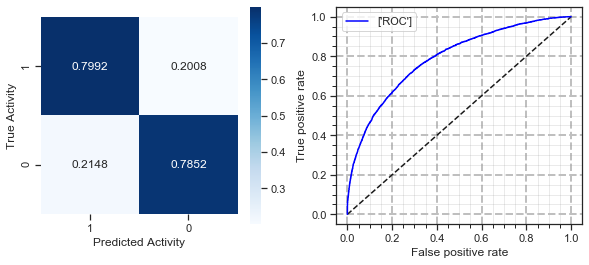

In [51]:
plot_acc_curve_2(loaded_model)